# Prep Notebook, Week 14, Part 1

So, the last lecture we ended passing data through Python to Altair to output as vega-lite.  What is the benefit to using Python for data analysis?  Well, for some of us Python is our bestie and so we want to hang out with it the most.  For others, the benefit is that we can do data cleaning in Python and then put the cleaned data into our plots.

Let's work through a few examples:

1. With the buildings dataset
1. With the corgis dataset

In [2]:
import pandas as pd
import numpy as np
import altair as alt
import matplotlib.pyplot as plt # just in case

## Review from last time:

In [3]:
data_url = 'https://github.com/UIUC-iSchool-DataViz/is445_data/raw/main/building_inventory.csv'
buildings = pd.read_csv(data_url, 
                        na_values = {"Square Footage":0,
                                   "Year Acquired":0,
                                   "Year Constructed":0})

Nice.  

Ok, now that we have our data cleaned, we can further transform our data by creating a statistics dataframe out of our data:

In [4]:
stats = buildings.groupby("Year Acquired")["Square Footage"].describe()

In [5]:
stats

count           mean           std       min       25%  \
Year Acquired                                                           
1753.0           1.0    1200.000000           NaN    1200.0    1200.0   
1802.0           2.0    2220.000000   1943.129435     846.0    1533.0   
1810.0           3.0    1344.333333   1809.945948     216.0     300.5   
1832.0           1.0  120000.000000           NaN  120000.0  120000.0   
1837.0           1.0   10302.000000           NaN   10302.0   10302.0   
...              ...            ...           ...       ...       ...   
2015.0          20.0   15254.650000  29153.085290     144.0     696.0   
2016.0          10.0   30483.900000  61864.180491    1152.0    2464.0   
2017.0           1.0    6720.000000           NaN    6720.0    6720.0   
2018.0           4.0    4290.000000   5153.644342    1455.0    1455.0   
2019.0           2.0     760.000000      0.000000     760.0     760.0   

                    50%        75%       max  
Year Acquired                                 
1753.0           1200.0    1200.00    1200.0  
1802.0           2220.0    2907.00    3594.0  
1810.0            385.0    1908.50    3432.0  
1832.0         120000.0  120000.00  120000.0  
1837.0          10302.0   10302.00   10302.0  
...                 ...        ...       ...  
2015.0           3152.0   10590.25  105000.0  
2016.0           3352.5    3793.00  184000.0  
2017.0           6720.0    6720.00    6720.0  
2018.0           1852.5    4687.50   12000.0  
2019.0            760.0     760.00     760.0  

[171 rows x 8 columns]

Update index format:

In [16]:
stats.index = pd.to_datetime(stats.index.astype('int'), format='%Y')

We made an initial plot of two lines by adding layers:

**Just copy the below:**

In [17]:
lines = alt.Chart(stats.reset_index()).encode(
    alt.X('Year Acquired:T')
).properties(
    width=800
)

lines = alt.layer(
    lines.mark_line(color='blue').encode(
        alt.Y('max:Q',scale=alt.Scale(type='log'))
             ),
    lines.mark_line(color='red').encode(
        alt.Y('min:Q',scale=alt.Scale(type='log'))
    )
)
lines

alt.LayerChart(...)

Neat!  Let's save this plot:

In [18]:
myJekyllDir = '/Users/jnaiman/jnaiman.github.io/'

In [19]:
lines.properties(width='container').save(myJekyllDir+"assets/json/buildings_sqft.json") 
# non-faceted chart, so can save with responsive size

Before moving on, we can make this ["easily" interactive with simple pans/zooms](https://altair-viz.github.io/altair-tutorial/notebooks/06-Selections.html):

In [20]:
lines = alt.Chart(stats.reset_index()).encode(
    alt.X('Year Acquired:T')
).properties(
    width=800
)

lines = alt.layer(
    lines.mark_line(color='blue').encode(
        alt.Y('max:Q',scale=alt.Scale(type='log'))
             ),
    lines.mark_line(color='red').encode(
        alt.Y('min:Q',scale=alt.Scale(type='log'))
    )
).interactive()
lines

alt.LayerChart(...)

Let's re-save this again:

In [21]:
lines.properties(width='container').save(myJekyllDir+"assets/json/buildings_sqft.json") 

## Adding more interactivity -- the "melt" function

### 1. Adding a mouse over for both lines

Porting from: https://altair-viz.github.io/gallery/multiline_tooltip.html#multi-line-tooltip

In [22]:
stats_min = stats[['min','max']]
stats_min.head()

min       max
Year Acquired                    
1753-01-01       1200.0    1200.0
1802-01-01        846.0    3594.0
1810-01-01        216.0    3432.0
1832-01-01     120000.0  120000.0
1837-01-01      10302.0   10302.0

In [23]:
# easier for multi-line plots
source = stats_min.reset_index().melt('Year Acquired', 
                                      var_name='Statistic', value_name='stat')
source.head()

Year Acquired Statistic      stat
0    1753-01-01       min    1200.0
1    1802-01-01       min     846.0
2    1810-01-01       min     216.0
3    1832-01-01       min  120000.0
4    1837-01-01       min   10302.0

In [24]:
# The basic line
#line = alt.Chart(source).mark_line(interpolate='basis').encode(
line = alt.Chart(source).mark_line().encode(
    alt.Y('stat:Q',scale=alt.Scale(type='log')),
    x='Year Acquired:T',
    color='Statistic:N'
).interactive()
line

alt.Chart(...)

In [25]:
# Create a selection that chooses the nearest point & selects based on x-value
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['Year Acquired'], empty='none')
# nearest = alt.selection(type='single', nearest=True, on='mouseover',
#                         encodings=['x'], empty='none')

# The basic line
line = alt.Chart(source).mark_line().encode(
    alt.Y('stat:Q',scale=alt.Scale(type='log')),
    x='Year Acquired:T',
    color='Statistic:N'
)

# Transparent selectors across the chart. This is what tells us
# the x-value of the cursor
selectors = alt.Chart(source).mark_point().encode(
    x='Year Acquired:T',
    opacity=alt.value(0),
).add_selection(
    nearest
)

# Draw points on the line, and highlight based on selection
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0))
)

# Draw text labels near the points, and highlight based on selection
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'stat:Q', alt.value(' '))
)

# Draw a rule at the location of the selection
rules = alt.Chart(source).mark_rule(color='gray').encode(
    x='Year Acquired:T',
).transform_filter(
    nearest
)

# Put the five layers into a chart and bind the data
alt.layer(
    line, selectors, points, rules, text
).properties(
    width=600, height=300
)

alt.LayerChart(...)

### 2. Deciding what statistic to plot with a dropdown

Porting from: https://altair-viz.github.io/user_guide/interactions.html#binding-adding-data-driven-inputs

In [26]:
source2 = stats.reset_index().melt('Year Acquired', 
                                      var_name='Statistic', value_name='stat')


In [27]:
source2.head()

Year Acquired Statistic  stat
0    1753-01-01     count   1.0
1    1802-01-01     count   2.0
2    1810-01-01     count   3.0
3    1832-01-01     count   1.0
4    1837-01-01     count   1.0

In [28]:
line = alt.Chart(source2).mark_line().encode(
    alt.Y('stat:Q',scale=alt.Scale(type='log')),
    x='Year Acquired:T',
    color='Statistic:N'
)
line

alt.Chart(...)

We see the above has some issues -- could be due to our scale choice, let's try w/o the log scale:

In [29]:
line = alt.Chart(source2).mark_line().encode(
    alt.Y('stat:Q'),#,scale=alt.Scale(type='log')),
    x='Year Acquired:T',
    color='Statistic:N'
)
line

alt.Chart(...)

So, we probably have some zeros to attend to:

In [30]:
source2['stat'].min()

0.0

In [31]:
source2.loc[source2['stat'] == 0,'stat'] = np.nan

In [32]:
line = alt.Chart(source2).mark_line().encode(
    alt.Y('stat:Q',scale=alt.Scale(type='log')),
    x='Year Acquired:T',
    color='Statistic:N'
)
line

alt.Chart(...)

In [33]:
input_dropdown = alt.binding_select(options=['50%','mean','min','max','std'], 
                                    name='Statistic')
selection = alt.selection_single(fields=['Statistic'], bind=input_dropdown)
color = alt.condition(selection,
                    alt.Color('Statistic:N', legend=None),
                    alt.value('lightgray'))

line = alt.Chart(source2).mark_line().encode(
    alt.Y('stat:Q',scale=alt.Scale(type='log')),
    x='Year Acquired:T',
    color=color
).add_selection(
    selection
)
line

alt.Chart(...)

A little hard to see some of those lines when they are "behind" others -- we can also mess with our opacity as well:

In [34]:
input_dropdown = alt.binding_select(options=['50%','mean','min','max','std'], 
                                    name='Statistic')
selection = alt.selection_single(fields=['Statistic'], bind=input_dropdown)
color = alt.condition(selection,
                    alt.Color('Statistic:N', legend=None),
                    alt.value('lightgray'))
opacity = alt.condition(selection, alt.value(1.0), alt.value(0.25))

line = alt.Chart(source2).mark_line().encode(
    alt.Y('stat:Q',scale=alt.Scale(type='log')),
    x='Year Acquired:T',
    color=color,
    opacity=opacity
).add_selection(
    selection
)
line

alt.Chart(...)

If we like this, we can save it as well:

In [35]:
line.properties(width='container').save(myJekyllDir+"assets/json/buildings_sqft_stats.json") 

## 2. Corgis Dataset examples

Let's start by reading in this dataset and taking a look -- we'll start with the number of corgis born over time:

In [36]:
corgs = pd.read_csv('https://raw.githubusercontent.com/UIUC-iSchool-DataViz/is445_data/main/corgs_per_country_over_time_columns_2020.csv')

In [37]:
corgs.head()

Years  United States  Brazil  Russia  Japan  Vietnam  Germany  France  \
0   1917              0       0       0      0        0        0       0   
1   1918              0       0       0      0        0        0       0   
2   1919              0       0       0      0        0        0       0   
3   1920              0       0       0      0        0        0       0   
4   1921              0       0       0      0        0        0       0   

   United Kingdom  Italy  ...  Croatia  New Zealand  Ireland  Lithuania  \
0               1      0  ...        0            0        0          0   
1               0      0  ...        0            0        0          0   
2               0      0  ...        0            0        0          0   
3               0      0  ...        0            0        0          0   
4               0      0  ...        0            0        0          0   

   Uruguay  Latvia  Slovenia  Estonia  Netherlands Antilles  Kosovo  
0        0       0         0        0                     0       0  
1        0       0         0        0                     0       0  
2        0       0         0        0                     0       1  
3        0       0         0        0                     0       0  
4        0       0         0        0                     0       0  

[5 rows x 41 columns]

So, this shows the number of corgis born over time in different countries.  The easiest plot we can think of is probably a line chart of each country over time.  First, let's start with the United States:

In [38]:
linecorg = alt.Chart(corgs).mark_line().encode(
    alt.X('Years:Q'),
    alt.Y('United States:Q')
)
linecorg

alt.Chart(...)

Here again, we probably want to specify that we have time units:

In [39]:
corgs['Years'] = pd.to_datetime(corgs['Years'].astype('int'), format='%Y')

In [40]:
corgs

Years  United States  Brazil  Russia  Japan  Vietnam  Germany  \
0   1917-01-01              0       0       0      0        0        0   
1   1918-01-01              0       0       0      0        0        0   
2   1919-01-01              0       0       0      0        0        0   
3   1920-01-01              0       0       0      0        0        0   
4   1921-01-01              0       0       0      0        0        0   
..         ...            ...     ...     ...    ...      ...      ...   
99  2016-01-01            229       0     217      2        0       54   
100 2017-01-01            213       0     260      2        1       28   
101 2018-01-01            198       0     329      0        3       42   
102 2019-01-01            118       0     189      0        0       30   
103 2020-01-01              2       0      16      0        0        0   

     France  United Kingdom  Italy  ...  Croatia  New Zealand  Ireland  \
0         0               1      0  ...        0            0        0   
1         0               0      0  ...        0            0        0   
2         0               0      0  ...        0            0        0   
3         0               0      0  ...        0            0        0   
4         0               0      0  ...        0            0        0   
..      ...             ...    ...  ...      ...          ...      ...   
99       55              28      2  ...        8            3        0   
100      60              10      4  ...        4            3        0   
101      25               5      2  ...        6            3        0   
102      62               1      2  ...        0            0        0   
103       0               0      0  ...        0            0        0   

     Lithuania  Uruguay  Latvia  Slovenia  Estonia  Netherlands Antilles  \
0            0        0       0         0        0                     0   
1            0        0       0         0        0                     0   
2            0        0       0         0        0                     0   
3            0        0       0         0        0                     0   
4            0        0       0         0        0                     0   
..         ...      ...     ...       ...      ...                   ...   
99           9        0       0         0       27                    17   
100          0        2       0         0        8                    25   
101          0        0       0         0       16                    12   
102          0        0       0         0       16                    12   
103          0        0       0         0        0                     0   

     Kosovo  
0         0  
1         0  
2         1  
3         0  
4         0  
..      ...  
99       72  
100     101  
101      56  
102      51  
103      17  

[104 rows x 41 columns]

In [41]:
linecorg = alt.Chart(corgs).mark_line().encode(
    alt.X('Years:T'),
    alt.Y('United States:Q')
)
linecorg

alt.Chart(...)

That looks better!  To make multiple lines for each country, we want to probably use the `melt` operation we did before. To do that, we need to make years the index:

In [42]:
corgs = corgs.set_index('Years')
corgs.head()

United States  Brazil  Russia  Japan  Vietnam  Germany  France  \
Years                                                                        
1917-01-01              0       0       0      0        0        0       0   
1918-01-01              0       0       0      0        0        0       0   
1919-01-01              0       0       0      0        0        0       0   
1920-01-01              0       0       0      0        0        0       0   
1921-01-01              0       0       0      0        0        0       0   

            United Kingdom  Italy  South Africa  ...  Croatia  New Zealand  \
Years                                            ...                         
1917-01-01               1      0             0  ...        0            0   
1918-01-01               0      0             0  ...        0            0   
1919-01-01               0      0             0  ...        0            0   
1920-01-01               0      0             0  ...        0            0   
1921-01-01               0      0             0  ...        0            0   

            Ireland  Lithuania  Uruguay  Latvia  Slovenia  Estonia  \
Years                                                                
1917-01-01        0          0        0       0         0        0   
1918-01-01        0          0        0       0         0        0   
1919-01-01        0          0        0       0         0        0   
1920-01-01        0          0        0       0         0        0   
1921-01-01        0          0        0       0         0        0   

            Netherlands Antilles  Kosovo  
Years                                     
1917-01-01                     0       0  
1918-01-01                     0       0  
1919-01-01                     0       1  
1920-01-01                     0       0  
1921-01-01                     0       0  

[5 rows x 40 columns]

Now we can "melt" like before:

In [43]:
corg_source = corgs.reset_index().melt('Years', 
                                      var_name='Country', value_name='country')

In [44]:
corg_source.head()

Years        Country  country
0 1917-01-01  United States        0
1 1918-01-01  United States        0
2 1919-01-01  United States        0
3 1920-01-01  United States        0
4 1921-01-01  United States        0

Now, let's try again with our multi-line plot:

In [45]:
linecorg = alt.Chart(corg_source).mark_line().encode(
    alt.Y('country:Q'),
    x='Years:T',
    color='Country:N'
)
linecorg

alt.Chart(...)

Since there is a large range of corgis born, we might try a log-scale on the y-axis:

In [46]:
linecorg = alt.Chart(corg_source).mark_line().encode(
    alt.Y('country:Q',scale=alt.Scale(type='log')),
    x='Years:T',
    color='Country:N'
)
linecorg

alt.Chart(...)

Here we see that there is an issue -- this is probably because there are zeros in our dataset:

In [47]:
corg_source['country'].min()

0

Potentially, we can "clean" these by setting any zeros to NaN's, however in this case those 0's are meaningful -- they are telling us that a particular country has no corgis born in that year!  Instead, we have a few different options.  One thing we can do [is apply a](https://stackoverflow.com/questions/58032074/why-is-altair-returning-an-empty-chart-when-using-log-scale) [filter opperation](https://altair-viz.github.io/user_guide/transform/filter.html#filter-transform) on our data:

In [48]:
linecorg = alt.Chart(corg_source).transform_filter(
    alt.datum.country > 0
).mark_line().encode(
    alt.Y('country:Q',scale=alt.Scale(type='log')),
    x='Years:T',
    color='Country:N'
)
linecorg

alt.Chart(...)

This doesn't really get to our issue though -- we are just filtering out those zero years/countries.  In this case, instead of filtering, we probably want to use a symmetric log instead of a log for our scale;

In [49]:
linecorg = alt.Chart(corg_source).mark_line().encode(
    alt.Y('country:Q',scale=alt.Scale(type='symlog')),
    x='Years:T',
    color='Country:N'
)
linecorg

alt.Chart(...)

Even with this though, we have sort of a messy plot -- even if we allowed for selections (like with the buildings dataset above) we still have many lines that "fall off" our legend which is not helpful.

Since this is data in different countries, we could think that maybe a good idea would be some kind of map!

First, let's see what mappable data "comes with" vega-datasets:

In [50]:
from vega_datasets import data

In [51]:
#data.countries

In [52]:
data.world_110m

Let's try plotting both of these:

In [53]:
geo = alt.topo_feature(data.world_110m.url, feature='countries')

# US states background
world = alt.Chart(geo).mark_geoshape(
    fill='gray',
    stroke='white'
).properties(
    width=800,
    height=500
).project('equirectangular') # note we have a few projections we can use!
world

alt.Chart(...)

So, one way we can plot data on this plot is to plot dots over each of the countries showing how many corgis have been born in each one.  For this though [we probably need the latitude and longitude points](https://altair-viz.github.io/altair-tutorial/notebooks/09-Geographic-plots.html).

One way to do this is [using the OpenStreetMap project](https://gis.stackexchange.com/questions/212796/getting-latlon-extent-of-country-by-its-name-using-python):

In [54]:
import requests
def get_boundingbox_country(country, output_as='center'):
    """
    get the bounding box of a country in EPSG4326 given a country name

    Parameters
    ----------
    country : str
        name of the country in english and lowercase
    output_as : 'str
        chose from 'boundingbox' or 'center'. 
         - 'boundingbox' for [latmin, latmax, lonmin, lonmax]
         - 'center' for [latcenter, loncenter]

    Returns
    -------
    output : list
        list with coordinates as str
    """
    # create url
    url = '{0}{1}{2}'.format('http://nominatim.openstreetmap.org/search?country=',
                             country,
                             '&format=json&polygon=0')
    response = requests.get(url).json()[0]

    # parse response to list
    if output_as == 'boundingbox':
        lst = response[output_as]
        output = [float(i) for i in lst]
    if output_as == 'center':
        lst = [response.get(key) for key in ['lat','lon']]
        output = [float(i) for i in lst]
    return output

We can call OpenStreetMaps in a few different ways, with country codes or names:

In [167]:
lat,long = get_boundingbox_country('usa')
lat,long

In [169]:
lat,long = get_boundingbox_country('us')
lat,long

(39.7837304, -100.445882)

In [171]:
lat,long = get_boundingbox_country('United States')
lat,long

(39.7837304, -100.445882)

There is no guarantee that the dataset is formatted with the correct country codes -- so we'd best check and see:

In [189]:
corgs.columns

Index(['United States', 'Brazil', 'Russia', 'Japan', 'Vietnam', 'Germany',
       'France', 'United Kingdom', 'Italy', 'South Africa', 'Ukraine', 'Spain',
       'Poland', 'Canada', 'Korea, North', 'Romania', 'Australia', 'Portugal',
       'Belgium', 'Czech Republic', 'Hungary', 'Belarus', 'Sweden', 'Austria',
       'Switzerland', 'Israel', 'Serbia', 'Denmark', 'Finland', 'Norway',
       'Croatia', 'New Zealand', 'Ireland', 'Lithuania', 'Uruguay', 'Latvia',
       'Slovenia', 'Estonia', 'Netherlands Antilles', 'Kosovo'],
      dtype='object')

In [190]:
lat,long = [],[]
for c in corgs.columns:
    la,lo = get_boundingbox_country(str(c))
    print(c,la,lo)
    lat.append(la); long.append(lo)

United States 39.7837304 -100.445882
Brazil -10.3333333 -53.2
Russia 64.6863136 97.7453061
Japan 36.5748441 139.2394179
Vietnam 15.9266657 107.9650855
Germany 51.1638175 10.4478313
France 46.603354 1.8883335
United Kingdom 54.7023545 -3.2765753
Italy 42.6384261 12.674297
South Africa -28.8166236 24.991639
Ukraine 49.4871968 31.2718321
Spain 39.3260685 -4.8379791
Poland 52.215933 19.134422
Canada 61.0666922 -107.991707


IndexError: list index out of range

Ah ha!  We have an issue, let's see what it is:

In [191]:
c

'Korea, North'

In this case, we need to do some data cleaning.  We can start from our "source" but instead, we probably want to start from the original dataframe, just to be consistent:

In [192]:
corg_clean = corgs.copy()
#corg_clean = corg_clean.set_index('Years') # note -- don't have to do this again since we started with a rest index
corg_clean = corg_clean.rename(columns={'Korea, North':"North Korea"})
corg_clean.head()

United States  Brazil  Russia  Japan  Vietnam  Germany  France  \
Years                                                                        
1917-01-01              0       0       0      0        0        0       0   
1918-01-01              0       0       0      0        0        0       0   
1919-01-01              0       0       0      0        0        0       0   
1920-01-01              0       0       0      0        0        0       0   
1921-01-01              0       0       0      0        0        0       0   

            United Kingdom  Italy  South Africa  ...  Croatia  New Zealand  \
Years                                            ...                         
1917-01-01               1      0             0  ...        0            0   
1918-01-01               0      0             0  ...        0            0   
1919-01-01               0      0             0  ...        0            0   
1920-01-01               0      0             0  ...        0            0   
1921-01-01               0      0             0  ...        0            0   

            Ireland  Lithuania  Uruguay  Latvia  Slovenia  Estonia  \
Years                                                                
1917-01-01        0          0        0       0         0        0   
1918-01-01        0          0        0       0         0        0   
1919-01-01        0          0        0       0         0        0   
1920-01-01        0          0        0       0         0        0   
1921-01-01        0          0        0       0         0        0   

            Netherlands Antilles  Kosovo  
Years                                     
1917-01-01                     0       0  
1918-01-01                     0       0  
1919-01-01                     0       1  
1920-01-01                     0       0  
1921-01-01                     0       0  

[5 rows x 40 columns]

Let's try this again:

In [193]:
lat,long = [],[]
for c in corg_clean.columns:
    la,lo = get_boundingbox_country(str(c))
    print(c,la,lo)
    lat.append(la); long.append(lo)

United States 39.7837304 -100.445882
Brazil -10.3333333 -53.2
Russia 64.6863136 97.7453061
Japan 36.5748441 139.2394179
Vietnam 15.9266657 107.9650855
Germany 51.1638175 10.4478313
France 46.603354 1.8883335
United Kingdom 54.7023545 -3.2765753
Italy 42.6384261 12.674297
South Africa -28.8166236 24.991639
Ukraine 49.4871968 31.2718321
Spain 39.3260685 -4.8379791
Poland 52.215933 19.134422
Canada 61.0666922 -107.991707
North Korea 40.3736611 127.0870417
Romania 45.9852129 24.6859225
Australia -24.7761086 134.755
Portugal 39.6621648 -8.1353519
Belgium 50.6402809 4.6667145
Czech Republic 49.7439047 15.3381061
Hungary 47.1817585 19.5060937
Belarus 53.4250605 27.6971358
Sweden 59.6749712 14.5208584
Austria 47.59397 14.12456
Switzerland 46.7985624 8.2319736
Israel 30.8124247 34.8594762
Serbia 44.1534121 20.55144
Denmark 55.670249 10.3333283
Finland 63.2467777 25.9209164
Norway 60.5000209 9.0999715
Croatia 45.5643442 17.0118954
New Zealand -41.5000831 172.8344077
Ireland 52.865196 -7.9794599


IndexError: list index out of range

In [194]:
c

'Netherlands Antilles'

Found another one:

In [195]:
corg_clean = corgs.copy()
corg_clean = corg_clean.rename(columns={'Korea, North':"North Korea",'Netherlands Antilles':"Netherlands"})

In [196]:
lat,long = [],[]
for c in corg_clean.columns:
    la,lo = get_boundingbox_country(str(c))
    print(c,la,lo)
    lat.append(la); long.append(lo)

United States 39.7837304 -100.445882
Brazil -10.3333333 -53.2
Russia 64.6863136 97.7453061
Japan 36.5748441 139.2394179
Vietnam 15.9266657 107.9650855
Germany 51.1638175 10.4478313
France 46.603354 1.8883335
United Kingdom 54.7023545 -3.2765753
Italy 42.6384261 12.674297
South Africa -28.8166236 24.991639
Ukraine 49.4871968 31.2718321
Spain 39.3260685 -4.8379791
Poland 52.215933 19.134422
Canada 61.0666922 -107.991707
North Korea 40.3736611 127.0870417
Romania 45.9852129 24.6859225
Australia -24.7761086 134.755
Portugal 39.6621648 -8.1353519
Belgium 50.6402809 4.6667145
Czech Republic 49.7439047 15.3381061
Hungary 47.1817585 19.5060937
Belarus 53.4250605 27.6971358
Sweden 59.6749712 14.5208584
Austria 47.59397 14.12456
Switzerland 46.7985624 8.2319736
Israel 30.8124247 34.8594762
Serbia 44.1534121 20.55144
Denmark 55.670249 10.3333283
Finland 63.2467777 25.9209164
Norway 60.5000209 9.0999715
Croatia 45.5643442 17.0118954
New Zealand -41.5000831 172.8344077
Ireland 52.865196 -7.9794599


Hurray!  So, this is a case where being able to clean the data in Python was super useful.  Let's try adding these as points to our map now that we have cleaned data.

One other data transformation we probably want to do is transpose this matrix so that we have countries as rows and corgis born per year as columns:

In [201]:
corg_clean_t = corg_clean.T
corg_clean_t.head()

Years          1917-01-01  1918-01-01  1919-01-01  1920-01-01  1921-01-01  \
United States           0           0           0           0           0   
Brazil                  0           0           0           0           0   
Russia                  0           0           0           0           0   
Japan                   0           0           0           0           0   
Vietnam                 0           0           0           0           0   

Years          1922-01-01  1923-01-01  1924-01-01  1925-01-01  1926-01-01  \
United States           0           0           0           0           0   
Brazil                  0           0           0           0           0   
Russia                  0           0           0           0           0   
Japan                   0           0           0           0           0   
Vietnam                 0           0           0           0           0   

Years          ...  2011-01-01  2012-01-01  2013-01-01  2014-01-01  \
United States  ...         408         431         376         280   
Brazil         ...           0           0           0           0   
Russia         ...          89          82         115         127   
Japan          ...           0           0           0           0   
Vietnam        ...           0           0           0           0   

Years          2015-01-01  2016-01-01  2017-01-01  2018-01-01  2019-01-01  \
United States         301         229         213         198         118   
Brazil                  0           0           0           0           0   
Russia                237         217         260         329         189   
Japan                   0           2           2           0           0   
Vietnam                 0           0           1           3           0   

Years          2020-01-01  
United States           2  
Brazil                  0  
Russia                 16  
Japan                   0  
Vietnam                 0  

[5 rows x 104 columns]

Since, technically, the index is no longer years, so we should be sure to name the index more intuatively: 

In [206]:
corg_clean_t.index.name = "Country"

In [478]:
corg_clean_t.axes[1].name

'Years'

In [473]:
corg_clean_t.head()

Years          1917-01-01 00:00:00  1918-01-01 00:00:00  1919-01-01 00:00:00  \
Country                                                                        
United States                    0                    0                    0   
Brazil                           0                    0                    0   
Russia                           0                    0                    0   
Japan                            0                    0                    0   
Vietnam                          0                    0                    0   

Years          1920-01-01 00:00:00  1921-01-01 00:00:00  1922-01-01 00:00:00  \
Country                                                                        
United States                    0                    0                    0   
Brazil                           0                    0                    0   
Russia                           0                    0                    0   
Japan                            0                    0                    0   
Vietnam                          0                    0                    0   

Years          1923-01-01 00:00:00  1924-01-01 00:00:00  1925-01-01 00:00:00  \
Country                                                                        
United States                    0                    0                    0   
Brazil                           0                    0                    0   
Russia                           0                    0                    0   
Japan                            0                    0                    0   
Vietnam                          0                    0                    0   

Years          1926-01-01 00:00:00  ...  2014-01-01 00:00:00  \
Country                             ...                        
United States                    0  ...                  280   
Brazil                           0  ...                    0   
Russia                           0  ...                  127   
Japan                            0  ...                    0   
Vietnam                          0  ...                    0   

Years          2015-01-01 00:00:00  2016-01-01 00:00:00  2017-01-01 00:00:00  \
Country                                                                        
United States                  301                  229                  213   
Brazil                           0                    0                    0   
Russia                         237                  217                  260   
Japan                            0                    2                    2   
Vietnam                          0                    0                    1   

Years          2018-01-01 00:00:00  2019-01-01 00:00:00  2020-01-01 00:00:00  \
Country                                                                        
United States                  198                  118                    2   
Brazil                           0                    0                    0   
Russia                         329                  189                   16   
Japan                            0                    0                    0   
Vietnam                          3                    0                    0   

Years           Latitude   Longitude  Total Corg  
Country                                           
United States  39.783730 -100.445882       16130  
Brazil        -10.333333  -53.200000           1  
Russia         64.686314   97.745306        1834  
Japan          36.574844  139.239418           7  
Vietnam        15.926666  107.965086           4  

[5 rows x 107 columns]

Now we can add in the lat/long for each country:

In [208]:
corg_clean_t['Latitude'] = lat
corg_clean_t['Longitude'] = long

In [209]:
corg_clean_t.head()

Years          1917-01-01 00:00:00  1918-01-01 00:00:00  1919-01-01 00:00:00  \
Country                                                                        
United States                    0                    0                    0   
Brazil                           0                    0                    0   
Russia                           0                    0                    0   
Japan                            0                    0                    0   
Vietnam                          0                    0                    0   

Years          1920-01-01 00:00:00  1921-01-01 00:00:00  1922-01-01 00:00:00  \
Country                                                                        
United States                    0                    0                    0   
Brazil                           0                    0                    0   
Russia                           0                    0                    0   
Japan                            0                    0                    0   
Vietnam                          0                    0                    0   

Years          1923-01-01 00:00:00  1924-01-01 00:00:00  1925-01-01 00:00:00  \
Country                                                                        
United States                    0                    0                    0   
Brazil                           0                    0                    0   
Russia                           0                    0                    0   
Japan                            0                    0                    0   
Vietnam                          0                    0                    0   

Years          1926-01-01 00:00:00  ...  2013-01-01 00:00:00  \
Country                             ...                        
United States                    0  ...                  376   
Brazil                           0  ...                    0   
Russia                           0  ...                  115   
Japan                            0  ...                    0   
Vietnam                          0  ...                    0   

Years          2014-01-01 00:00:00  2015-01-01 00:00:00  2016-01-01 00:00:00  \
Country                                                                        
United States                  280                  301                  229   
Brazil                           0                    0                    0   
Russia                         127                  237                  217   
Japan                            0                    0                    2   
Vietnam                          0                    0                    0   

Years          2017-01-01 00:00:00  2018-01-01 00:00:00  2019-01-01 00:00:00  \
Country                                                                        
United States                  213                  198                  118   
Brazil                           0                    0                    0   
Russia                         260                  329                  189   
Japan                            2                    0                    0   
Vietnam                          1                    3                    0   

Years          2020-01-01 00:00:00   Latitude   Longitude  
Country                                                    
United States                    2  39.783730 -100.445882  
Brazil                           0 -10.333333  -53.200000  
Russia                          16  64.686314   97.745306  
Japan                            0  36.574844  139.239418  
Vietnam                          0  15.926666  107.965086  

[5 rows x 106 columns]

Now (finally) we can plot those points on our map using just the lat/long:

In [220]:
corg_subset = corg_clean_t.reset_index()[['Country','Latitude','Longitude']]
corg_subset.head()

Years        Country   Latitude   Longitude
0      United States  39.783730 -100.445882
1             Brazil -10.333333  -53.200000
2             Russia  64.686314   97.745306
3              Japan  36.574844  139.239418
4            Vietnam  15.926666  107.965086

In [224]:
geo = alt.topo_feature(data.world_110m.url, feature='countries')

# US states background
world = alt.Chart(geo).mark_geoshape(
    fill='gray',
    stroke='white'
).properties(
    width=800,
    height=500
).project('equirectangular') # note we have a few projections we can use!

points = alt.Chart(corg_subset).mark_circle().encode(
    longitude='Longitude:Q',
    latitude='Latitude:Q',
    size=alt.value(100),
    tooltip='Country'
)

world + points

alt.LayerChart(...)

We probably want the size of the dot to be proportional to the actual number of corgis born.

To start, let's just plot the total corgis born in a country:

In [216]:
corg_clean_t.loc[:, (corg_clean_t.columns != 'Longitude') & (corg_clean_t.columns != "Latitude")].head()

Years          1917-01-01  1918-01-01  1919-01-01  1920-01-01  1921-01-01  \
Country                                                                     
United States           0           0           0           0           0   
Brazil                  0           0           0           0           0   
Russia                  0           0           0           0           0   
Japan                   0           0           0           0           0   
Vietnam                 0           0           0           0           0   

Years          1922-01-01  1923-01-01  1924-01-01  1925-01-01  1926-01-01  \
Country                                                                     
United States           0           0           0           0           0   
Brazil                  0           0           0           0           0   
Russia                  0           0           0           0           0   
Japan                   0           0           0           0           0   
Vietnam                 0           0           0           0           0   

Years          ...  2011-01-01  2012-01-01  2013-01-01  2014-01-01  \
Country        ...                                                   
United States  ...         408         431         376         280   
Brazil         ...           0           0           0           0   
Russia         ...          89          82         115         127   
Japan          ...           0           0           0           0   
Vietnam        ...           0           0           0           0   

Years          2015-01-01  2016-01-01  2017-01-01  2018-01-01  2019-01-01  \
Country                                                                     
United States         301         229         213         198         118   
Brazil                  0           0           0           0           0   
Russia                237         217         260         329         189   
Japan                   0           2           2           0           0   
Vietnam                 0           0           1           3           0   

Years          2020-01-01  
Country                    
United States           2  
Brazil                  0  
Russia                 16  
Japan                   0  
Vietnam                 0  

[5 rows x 104 columns]

Now we can sum along the Country axis:

In [214]:
corg_clean_t.loc[:, (corg_clean_t.columns != 'Longitude') & (corg_clean_t.columns != "Latitude")].sum(axis=1)

Country
United States     16130
Brazil                1
Russia             1834
Japan                 7
Vietnam               4
Germany             892
France              597
United Kingdom     2649
Italy               106
South Africa         28
Ukraine              19
Spain                 5
Poland              859
Canada              391
North Korea           5
Romania               7
Australia           891
Portugal              7
Belgium             110
Czech Republic      271
Hungary               8
Belarus              38
Sweden             2008
Austria              29
Switzerland          30
Israel               32
Serbia                2
Denmark            2176
Finland            4051
Norway             1077
Croatia              21
New Zealand        1097
Ireland              29
Lithuania            29
Uruguay               2
Latvia                3
Slovenia              1
Estonia              97
Netherlands         536
Kosovo              649
dtype: int64

In [217]:
corg_clean_t['Total Corg'] = corg_clean_t.loc[:, (corg_clean_t.columns != 'Longitude') & (corg_clean_t.columns != "Latitude")].sum(axis=1).values

In [218]:
corg_clean_t.head()

Years          1917-01-01 00:00:00  1918-01-01 00:00:00  1919-01-01 00:00:00  \
Country                                                                        
United States                    0                    0                    0   
Brazil                           0                    0                    0   
Russia                           0                    0                    0   
Japan                            0                    0                    0   
Vietnam                          0                    0                    0   

Years          1920-01-01 00:00:00  1921-01-01 00:00:00  1922-01-01 00:00:00  \
Country                                                                        
United States                    0                    0                    0   
Brazil                           0                    0                    0   
Russia                           0                    0                    0   
Japan                            0                    0                    0   
Vietnam                          0                    0                    0   

Years          1923-01-01 00:00:00  1924-01-01 00:00:00  1925-01-01 00:00:00  \
Country                                                                        
United States                    0                    0                    0   
Brazil                           0                    0                    0   
Russia                           0                    0                    0   
Japan                            0                    0                    0   
Vietnam                          0                    0                    0   

Years          1926-01-01 00:00:00  ...  2014-01-01 00:00:00  \
Country                             ...                        
United States                    0  ...                  280   
Brazil                           0  ...                    0   
Russia                           0  ...                  127   
Japan                            0  ...                    0   
Vietnam                          0  ...                    0   

Years          2015-01-01 00:00:00  2016-01-01 00:00:00  2017-01-01 00:00:00  \
Country                                                                        
United States                  301                  229                  213   
Brazil                           0                    0                    0   
Russia                         237                  217                  260   
Japan                            0                    2                    2   
Vietnam                          0                    0                    1   

Years          2018-01-01 00:00:00  2019-01-01 00:00:00  2020-01-01 00:00:00  \
Country                                                                        
United States                  198                  118                    2   
Brazil                           0                    0                    0   
Russia                         329                  189                   16   
Japan                            0                    0                    0   
Vietnam                          3                    0                    0   

Years           Latitude   Longitude  Total Corg  
Country                                           
United States  39.783730 -100.445882       16130  
Brazil        -10.333333  -53.200000           1  
Russia         64.686314   97.745306        1834  
Japan          36.574844  139.239418           7  
Vietnam        15.926666  107.965086           4  

[5 rows x 107 columns]

Let's again subset our data:

In [225]:
corg_subset2 = corg_clean_t.reset_index()[['Country','Latitude','Longitude','Total Corg']]

In [235]:
geo = alt.topo_feature(data.world_110m.url, feature='countries')

# US states background
world = alt.Chart(geo).mark_geoshape(
    fill='gray',
    stroke='white'
).properties(
    width=800,
    height=500
).project('equirectangular') # note we have a few projections we can use!

points = alt.Chart(corg_subset2).mark_circle().encode(
    longitude='Longitude:Q',
    latitude='Latitude:Q',
    size=alt.Size('Total Corg:Q'),
    tooltip='Country',
)

world + points

alt.LayerChart(...)

By default, we see that there is some scale applied to the points where there are some that are very small.  Let's see if we can mess with this:

In [236]:
geo = alt.topo_feature(data.world_110m.url, feature='countries')

# US states background
world = alt.Chart(geo).mark_geoshape(
    fill='gray',
    stroke='white'
).properties(
    width=800,
    height=500
).project('equirectangular') # note we have a few projections we can use!

points = alt.Chart(corg_subset2).mark_circle().encode(
    longitude='Longitude:Q',
    latitude='Latitude:Q',
    size=alt.Size('Total Corg:Q',scale=None),
    tooltip='Country',
)

world + points

alt.LayerChart(...)

Whoa!  Now that seems to have gone the other way!  Now we have so many overlapping points that its hard to see in "high corgi" areas like the UK.  Let's try a log scale:

In [237]:
geo = alt.topo_feature(data.world_110m.url, feature='countries')

# US states background
world = alt.Chart(geo).mark_geoshape(
    fill='gray',
    stroke='white'
).properties(
    width=800,
    height=500
).project('equirectangular') # note we have a few projections we can use!

points = alt.Chart(corg_subset2).mark_circle().encode(
    longitude='Longitude:Q',
    latitude='Latitude:Q',
    size=alt.Size('Total Corg:Q',scale=alt.Scale(type='log')),
    tooltip='Country',
)

world + points

alt.LayerChart(...)

Hey that looks better!  Though, that blue is a bit hard to see, let's try messing with the colors:

In [238]:
geo = alt.topo_feature(data.world_110m.url, feature='countries')

# US states background
world = alt.Chart(geo).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    width=800,
    height=500
).project('equirectangular') # note we have a few projections we can use!

points = alt.Chart(corg_subset2).mark_circle().encode(
    longitude='Longitude:Q',
    latitude='Latitude:Q',
    size=alt.Size('Total Corg:Q',scale=alt.Scale(type='log')),
    tooltip='Country',
)

world + points

alt.LayerChart(...)

Neat!  Now, wouldn't it be fun if we could see those data points "grow" over time.  Let's look at our dataframe again:

In [239]:
corg_clean_t.head()

Years          1917-01-01 00:00:00  1918-01-01 00:00:00  1919-01-01 00:00:00  \
Country                                                                        
United States                    0                    0                    0   
Brazil                           0                    0                    0   
Russia                           0                    0                    0   
Japan                            0                    0                    0   
Vietnam                          0                    0                    0   

Years          1920-01-01 00:00:00  1921-01-01 00:00:00  1922-01-01 00:00:00  \
Country                                                                        
United States                    0                    0                    0   
Brazil                           0                    0                    0   
Russia                           0                    0                    0   
Japan                            0                    0                    0   
Vietnam                          0                    0                    0   

Years          1923-01-01 00:00:00  1924-01-01 00:00:00  1925-01-01 00:00:00  \
Country                                                                        
United States                    0                    0                    0   
Brazil                           0                    0                    0   
Russia                           0                    0                    0   
Japan                            0                    0                    0   
Vietnam                          0                    0                    0   

Years          1926-01-01 00:00:00  ...  2014-01-01 00:00:00  \
Country                             ...                        
United States                    0  ...                  280   
Brazil                           0  ...                    0   
Russia                           0  ...                  127   
Japan                            0  ...                    0   
Vietnam                          0  ...                    0   

Years          2015-01-01 00:00:00  2016-01-01 00:00:00  2017-01-01 00:00:00  \
Country                                                                        
United States                  301                  229                  213   
Brazil                           0                    0                    0   
Russia                         237                  217                  260   
Japan                            0                    2                    2   
Vietnam                          0                    0                    1   

Years          2018-01-01 00:00:00  2019-01-01 00:00:00  2020-01-01 00:00:00  \
Country                                                                        
United States                  198                  118                    2   
Brazil                           0                    0                    0   
Russia                         329                  189                   16   
Japan                            0                    0                    0   
Vietnam                          3                    0                    0   

Years           Latitude   Longitude  Total Corg  
Country                                           
United States  39.783730 -100.445882       16130  
Brazil        -10.333333  -53.200000           1  
Russia         64.686314   97.745306        1834  
Japan          36.574844  139.239418           7  
Vietnam        15.926666  107.965086           4  

[5 rows x 107 columns]

Instead of total corgs overall, what we really want is total corgs over time. Luckily, our columns are in the correct date order:

In [244]:
corg_clean2 = corg_clean_t.loc[:,(corg_clean_t.columns != 'Total Corg')].copy()
corg_clean2.head()

Years          1917-01-01 00:00:00  1918-01-01 00:00:00  1919-01-01 00:00:00  \
Country                                                                        
United States                    0                    0                    0   
Brazil                           0                    0                    0   
Russia                           0                    0                    0   
Japan                            0                    0                    0   
Vietnam                          0                    0                    0   

Years          1920-01-01 00:00:00  1921-01-01 00:00:00  1922-01-01 00:00:00  \
Country                                                                        
United States                    0                    0                    0   
Brazil                           0                    0                    0   
Russia                           0                    0                    0   
Japan                            0                    0                    0   
Vietnam                          0                    0                    0   

Years          1923-01-01 00:00:00  1924-01-01 00:00:00  1925-01-01 00:00:00  \
Country                                                                        
United States                    0                    0                    0   
Brazil                           0                    0                    0   
Russia                           0                    0                    0   
Japan                            0                    0                    0   
Vietnam                          0                    0                    0   

Years          1926-01-01 00:00:00  ...  2013-01-01 00:00:00  \
Country                             ...                        
United States                    0  ...                  376   
Brazil                           0  ...                    0   
Russia                           0  ...                  115   
Japan                            0  ...                    0   
Vietnam                          0  ...                    0   

Years          2014-01-01 00:00:00  2015-01-01 00:00:00  2016-01-01 00:00:00  \
Country                                                                        
United States                  280                  301                  229   
Brazil                           0                    0                    0   
Russia                         127                  237                  217   
Japan                            0                    0                    2   
Vietnam                          0                    0                    0   

Years          2017-01-01 00:00:00  2018-01-01 00:00:00  2019-01-01 00:00:00  \
Country                                                                        
United States                  213                  198                  118   
Brazil                           0                    0                    0   
Russia                         260                  329                  189   
Japan                            2                    0                    0   
Vietnam                          1                    3                    0   

Years          2020-01-01 00:00:00   Latitude   Longitude  
Country                                                    
United States                    2  39.783730 -100.445882  
Brazil                           0 -10.333333  -53.200000  
Russia                          16  64.686314   97.745306  
Japan                            0  36.574844  139.239418  
Vietnam                          0  15.926666  107.965086  

[5 rows x 106 columns]

In [246]:
corg_clean2.loc[:,(corg_clean2.columns != 'Latitude') & (corg_clean2.columns!='Longitude')].head()

Years          1917-01-01  1918-01-01  1919-01-01  1920-01-01  1921-01-01  \
Country                                                                     
United States           0           0           0           0           0   
Brazil                  0           0           0           0           0   
Russia                  0           0           0           0           0   
Japan                   0           0           0           0           0   
Vietnam                 0           0           0           0           0   

Years          1922-01-01  1923-01-01  1924-01-01  1925-01-01  1926-01-01  \
Country                                                                     
United States           0           0           0           0           0   
Brazil                  0           0           0           0           0   
Russia                  0           0           0           0           0   
Japan                   0           0           0           0           0   
Vietnam                 0           0           0           0           0   

Years          ...  2011-01-01  2012-01-01  2013-01-01  2014-01-01  \
Country        ...                                                   
United States  ...         408         431         376         280   
Brazil         ...           0           0           0           0   
Russia         ...          89          82         115         127   
Japan          ...           0           0           0           0   
Vietnam        ...           0           0           0           0   

Years          2015-01-01  2016-01-01  2017-01-01  2018-01-01  2019-01-01  \
Country                                                                     
United States         301         229         213         198         118   
Brazil                  0           0           0           0           0   
Russia                237         217         260         329         189   
Japan                   0           2           2           0           0   
Vietnam                 0           0           1           3           0   

Years          2020-01-01  
Country                    
United States           2  
Brazil                  0  
Russia                 16  
Japan                   0  
Vietnam                 0  

[5 rows x 104 columns]

In [250]:
corg_clean2.loc[:,(corg_clean2.columns != 'Latitude') & (corg_clean2.columns!='Longitude')].cumsum(axis=1)

Years           1917-01-01  1918-01-01  1919-01-01  1920-01-01  1921-01-01  \
Country                                                                      
United States            0           0           0           0           0   
Brazil                   0           0           0           0           0   
Russia                   0           0           0           0           0   
Japan                    0           0           0           0           0   
Vietnam                  0           0           0           0           0   
Germany                  0           0           0           0           0   
France                   0           0           0           0           0   
United Kingdom           1           1           1           1           1   
Italy                    0           0           0           0           0   
South Africa             0           0           0           0           0   
Ukraine                  0           0           0           0           0   
Spain                    0           0           0           0           0   
Poland                   0           0           0           0           0   
Canada                   0           0           0           0           0   
North Korea              0           0           0           0           0   
Romania                  0           0           0           0           0   
Australia                0           0           0           0           0   
Portugal                 0           0           0           0           0   
Belgium                  0           0           0           0           0   
Czech Republic           0           0           0           0           0   
Hungary                  0           0           0           0           0   
Belarus                  0           0           0           0           0   
Sweden                   0           0           0           0           0   
Austria                  0           0           0           0           0   
Switzerland              0           0           0           0           0   
Israel                   0           0           0           0           0   
Serbia                   0           0           0           0           0   
Denmark                  0           0           0           0           0   
Finland                  0           0           0           0           0   
Norway                   0           0           0           0           0   
Croatia                  0           0           0           0           0   
New Zealand              0           0           0           0           0   
Ireland                  0           0           0           0           0   
Lithuania                0           0           0           0           0   
Uruguay                  0           0           0           0           0   
Latvia                   0           0           0           0           0   
Slovenia                 0           0           0           0           0   
Estonia                  0           0           0           0           0   
Netherlands              0           0           0           0           0   
Kosovo                   0           0           1           1           1   

Years           1922-01-01  1923-01-01  1924-01-01  1925-01-01  1926-01-01  \
Country                                                                      
United States            0           0           0           0           0   
Brazil                   0           0           0           0           0   
Russia                   0           0           0           0           0   
Japan                    0           0           0           0           0   
Vietnam                  0           0           0           0           0   
Germany                  0           0           0           0           0   
France                   0           0           0           0           0   
United Kingdom       

In [251]:
corg_clean2.loc[:,(corg_clean2.columns != 'Latitude') & (corg_clean2.columns!='Longitude')] = \
  corg_clean2.loc[:,(corg_clean2.columns != 'Latitude') & (corg_clean2.columns!='Longitude')].cumsum(axis=1)

In [252]:
corg_clean2

Years           1917-01-01 00:00:00  1918-01-01 00:00:00  1919-01-01 00:00:00  \
Country                                                                         
United States                     0                    0                    0   
Brazil                            0                    0                    0   
Russia                            0                    0                    0   
Japan                             0                    0                    0   
Vietnam                           0                    0                    0   
Germany                           0                    0                    0   
France                            0                    0                    0   
United Kingdom                    1                    1                    1   
Italy                             0                    0                    0   
South Africa                      0                    0                    0   
Ukraine                           0                    0                    0   
Spain                             0                    0                    0   
Poland                            0                    0                    0   
Canada                            0                    0                    0   
North Korea                       0                    0                    0   
Romania                           0                    0                    0   
Australia                         0                    0                    0   
Portugal                          0                    0                    0   
Belgium                           0                    0                    0   
Czech Republic                    0                    0                    0   
Hungary                           0                    0                    0   
Belarus                           0                    0                    0   
Sweden                            0                    0                    0   
Austria                           0                    0                    0   
Switzerland                       0                    0                    0   
Israel                            0                    0                    0   
Serbia                            0                    0                    0   
Denmark                           0                    0                    0   
Finland                           0                    0                    0   
Norway                            0                    0                    0   
Croatia                           0                    0                    0   
New Zealand                       0                    0                    0   
Ireland                           0                    0                    0   
Lithuania                         0                    0                    0   
Uruguay                           0                    0                    0   
Latvia                            0                    0                    0   
Slovenia                          0                    0                    0   
Estonia                           0                    0                    0   
Netherlands                       0                    0                    0   
Kosovo                            0                    0                    1   

Years           1920-01-01 00:00:00  1921-01-01 00:00:00  1922-01-01 00:00:00  \
Country                                                                         
United States                     0                    0                    0   
Brazil                            0                    0                    0   
Russia                            0                    0                    0   
Japan                             0                    0                    0   
Vietnam                           0                    0                    0   
Germany                       

In [254]:
corg_clean2.reset_index()

Years         Country  1917-01-01 00:00:00  1918-01-01 00:00:00  \
0       United States                    0                    0   
1              Brazil                    0                    0   
2              Russia                    0                    0   
3               Japan                    0                    0   
4             Vietnam                    0                    0   
5             Germany                    0                    0   
6              France                    0                    0   
7      United Kingdom                    1                    1   
8               Italy                    0                    0   
9        South Africa                    0                    0   
10            Ukraine                    0                    0   
11              Spain                    0                    0   
12             Poland                    0                    0   
13             Canada                    0                    0   
14        North Korea                    0                    0   
15            Romania                    0                    0   
16          Australia                    0                    0   
17           Portugal                    0                    0   
18            Belgium                    0                    0   
19     Czech Republic                    0                    0   
20            Hungary                    0                    0   
21            Belarus                    0                    0   
22             Sweden                    0                    0   
23            Austria                    0                    0   
24        Switzerland                    0                    0   
25             Israel                    0                    0   
26             Serbia                    0                    0   
27            Denmark                    0                    0   
28            Finland                    0                    0   
29             Norway                    0                    0   
30            Croatia                    0                    0   
31        New Zealand                    0                    0   
32            Ireland                    0                    0   
33          Lithuania                    0                    0   
34            Uruguay                    0                    0   
35             Latvia                    0                    0   
36           Slovenia                    0                    0   
37            Estonia                    0                    0   
38        Netherlands                    0                    0   
39             Kosovo                    0                    0   

Years  1919-01-01 00:00:00  1920-01-01 00:00:00  1921-01-01 00:00:00  \
0                        0                    0                    0   
1                        0                    0                    0   
2                        0                    0                    0   
3                        0                    0                    0   
4                        0                    0                    0   
5                        0                    0                    0   
6                        0                    0                    0   
7                        1                    1                    1   
8                        0                    0                    0   
9                        0                    0                    0   
10                       0                    0                    0   
11                       0                    0                    0   
12                       0                    0                    0   
13                       0                    0                    0   
14                       0                    0                    0   
15                       0                    0                    0   
16                       0  

Now let's "remelt" the data into a format we can use for our plot:

In [289]:
corg_melt = corg_clean2.reset_index().melt(['Country','Longitude','Latitude'], 
                                      var_name='Year', value_name='cumulative_sum')
corg_melt.head()

Country   Longitude   Latitude       Year  cumulative_sum
0  United States -100.445882  39.783730 1917-01-01               0
1         Brazil  -53.200000 -10.333333 1917-01-01               0
2         Russia   97.745306  64.686314 1917-01-01               0
3          Japan  139.239418  36.574844 1917-01-01               0
4        Vietnam  107.965086  15.926666 1917-01-01               0

Now we can make a little [slider in Altair](https://altair-viz.github.io/user_guide/interactions.html#selection-values-in-expressions) to change the date range for our circles interactively:

In [290]:
corg_melt['Year'].min(), corg_melt['Year'].max()

(Timestamp('1917-01-01 00:00:00'), Timestamp('2020-01-01 00:00:00'))

Since sliders (at least at the time of writing) [can't have datetime inputs](https://stackoverflow.com/questions/62046930/altair-adding-date-slider-for-interactive-scatter-chart-pot) let's cheat a bit by making another column called "year_int":

In [291]:
corg_melt['year_int'] = corg_melt['Year'].dt.year.astype('int')
corg_melt.head()

Country   Longitude   Latitude       Year  cumulative_sum  year_int
0  United States -100.445882  39.783730 1917-01-01               0      1917
1         Brazil  -53.200000 -10.333333 1917-01-01               0      1917
2         Russia   97.745306  64.686314 1917-01-01               0      1917
3          Japan  139.239418  36.574844 1917-01-01               0      1917
4        Vietnam  107.965086  15.926666 1917-01-01               0      1917

Note here to that for [equity selections we don't have to use == signs](https://stackoverflow.com/questions/68071713/in-altair-equality-condition-doesnt-work) in Altair (it won't work... just for fun I guess).

In [342]:
slider = alt.binding_range(min=corg_melt['year_int'].min(), 
                           max=corg_melt['year_int'].max(), step=1, name='Max year:')
#selector = alt.selection_single(name="SelectorName", fields=['cutoff'],
#                                bind=slider, init={'cutoff': 2000})
selector = alt.selection_single(name="SelectorName", fields=['year_int'],
                                bind=slider, init={'year_int': 2000})

In [343]:
geo = alt.topo_feature(data.world_110m.url, feature='countries')

# US states background
world = alt.Chart(geo).mark_geoshape(
    fill='lightgray',
    stroke='white'
).properties(
    width=800,
    height=500
).project('equirectangular') # note we have a few projections we can use!

points = alt.Chart(corg_melt).mark_circle().encode(
    longitude='Longitude:Q',
    latitude='Latitude:Q',
    #size=alt.Size('Total Corg:Q',scale=alt.Scale(type='log')),
    size=alt.condition(
        #((alt.datum.year_int < selector.cutoff-10)&(alt.datum.year_int >= selector.cutoff)),
        #(alt.datum.year_int == selector.cutoff),
        #"datum.year_int == selector.cutoff",
        #alt.expr.datum['year_int'] < selector.cutoff,
        selector,
        alt.Size('cumulative_sum:Q',scale=None), alt.value(0)
    ),
    tooltip='Country',
).add_selection(
    selector
)

world + points

alt.LayerChart(...)

One final thing, let's add in some info about what each dot means in our tooltip:

In [344]:
geo = alt.topo_feature(data.world_110m.url, feature='countries')

# US states background
world = alt.Chart(geo).mark_geoshape(
    fill='lightgray',
    stroke='black'
).properties(
    width=800,
    height=500
#).project('mercator') # note we have a few projections we can use!
).project('equirectangular') # note we have a few projections we can use!

points = alt.Chart(corg_melt).mark_circle().encode(
    longitude='Longitude:Q',
    latitude='Latitude:Q',
    #size=alt.Size('Total Corg:Q',scale=alt.Scale(type='log')),
    size=alt.condition(
        #((alt.datum.year_int < selector.year_int-10)&(alt.datum.year_int >= selector.year_int)),
        #(alt.datum.year_int < selector.year_int),
        #"datum.year_int == selector.year_int",
        #alt.expr.datum['year_int'] < selector.year_int,
        selector,
        alt.Size('cumulative_sum:Q',scale=None), alt.value(0)
    ),
    tooltip=['Country','cumulative_sum'],
).add_selection(
    selector
)

world + points

alt.LayerChart(...)

Looks nice!  Let's save it:

In [345]:
chart_out = world + points

chart_out.properties(width='container').save(myJekyllDir+"assets/json/corgis_dotchart_world.json") 

We note that when we run this though, we get a few artifacts.  We can try to "smooth" the transitions with a bit of interpolation:

In [336]:
alt.selection_single?

In [346]:
slider = alt.binding_range(min=corg_melt['year_int'].min(), 
                           max=corg_melt['year_int'].max(), step=1, name='Max year:')
selector = alt.selection_single(name="SelectorName", fields=['year_int'],
                                bind=slider, init={'year_int': corg_melt['year_int'].min()},
                               nearest=True)

In [347]:
geo = alt.topo_feature(data.world_110m.url, feature='countries')

# US states background
world = alt.Chart(geo).mark_geoshape(
    fill='lightgray',
    stroke='black'
).properties(
    width=800,
    height=500
#).project('mercator') # note we have a few projections we can use!
).project('equirectangular') # note we have a few projections we can use!

points = alt.Chart(corg_melt).mark_circle().encode(
    longitude='Longitude:Q',
    latitude='Latitude:Q',
    #size=alt.Size('Total Corg:Q',scale=alt.Scale(type='log')),
    size=alt.condition(
        #((alt.datum.year_int < selector.year_int-10)&(alt.datum.year_int >= selector.year_int)),
        #(alt.datum.year_int < selector.year_int),
        #"datum.year_int == selector.year_int",
        #alt.expr.datum['year_int'] < selector.year_int,
        selector,
        alt.Size('cumulative_sum:Q',scale=None), alt.value(0)
    ),
    tooltip=['Country','cumulative_sum'],
).add_selection(
    selector
)

world + points

alt.LayerChart(...)

In [348]:
chart_out = world + points

chart_out.properties(width='container').save(myJekyllDir+"assets/json/corgis_dotchart_world_smooth.json") 

Groovy!

One thing to note here is how much of the data cleaning and transformation we ended up doing in Python.  In theory one probably *could* do this in Altair/vega-lite, but not without a lot of headache and in Python, we have the option of checking each "stage" of our data transformation so we can make sure it makes sense -- in vega-lite/Altair, we don't really have this option (as easily).

### Corgi data and choropleth

One final thing (well, not final final, there are infinite things we can do!) is to instead of plotting points on a map, we can color the a map of the world by the population of corgis at a particular time.  

This is called a [choropleth map](https://altair-viz.github.io/gallery/choropleth.html), and this is probably the last time I will EVER spell that correctly :D 

These can be [a little tricky in Altair](https://altair-viz.github.io/altair-tutorial/notebooks/09-Geographic-plots.html#colored-choropleths) since you have to map between pre-determined names of countries (as stored in the vegadataset world map) and however your data is stored.

Let's start with just coloring our mappable data based on the total corgis born.  First, based on the [documentation about how to do this](https://altair-viz.github.io/altair-tutorial/notebooks/09-Geographic-plots.html#colored-choropleths) we know that we have to match up the world-map ID with whatever ID for each country as listed in our dataset.  There are also some [other transformation-related things to be aware of](https://stackoverflow.com/questions/59224026/how-to-add-a-slider-to-a-choropleth-in-altair) that we'll cover after we deal with the ID look up stuff.


Let's dig a bit deeper with geopandas:

In [724]:
import geopandas

In [725]:
data.world_110m.url

'https://cdn.jsdelivr.net/npm/vega-datasets@v1.29.0/data/world-110m.json'

In [726]:
gdf = geopandas.read_file(data.world_110m.url,include_fields=['name'],layer='countries')

In [727]:
gdf

id                                           geometry
0      4  POLYGON ((61.20961 35.64925, 62.23202 35.27011...
1     24  MULTIPOLYGON (((23.91324 -10.92658, 24.01764 -...
2      8  POLYGON ((20.59041 41.85586, 20.46440 41.51565...
3    784  POLYGON ((51.57952 24.24479, 51.75592 24.29387...
4     32  MULTIPOLYGON (((-66.95887 -54.89756, -67.56368...
..   ...                                                ...
172  548  MULTIPOLYGON (((167.51508 -16.59835, 167.18027...
173  887  POLYGON ((52.38592 16.38285, 52.19152 15.93771...
174  710  POLYGON ((28.21888 -32.77244, 27.46287 -33.227...
175  894  POLYGON ((32.75853 -9.23064, 33.23013 -9.67747...
176  716  POLYGON ((31.19251 -22.25149, 30.65971 -22.151...

[177 rows x 2 columns]

So, here we see that there is this ID -- this matches up with each country, for example:

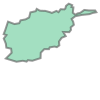

In [728]:
gdf.iloc[0]['geometry']

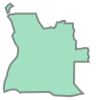

In [729]:
gdf.iloc[1]['geometry']

Are both countries!  But how to find out which ones?

To do that, we have to map the ID's to their [world country codes](https://documentation-resources.opendatasoft.com/explore/dataset/natural-earth-countries-110m/information/).  Luckily, that is [already done for us](https://github.com/alisle/world-110m-country-codes).

In [730]:
country_codes = pd.read_json('https://raw.githubusercontent.com/alisle/world-110m-country-codes/master/world-110m-country-codes.json')

In [731]:
country_codes.head()

code  id         name
0   AF   4  Afghanistan
1   AL   8      Albania
2   DZ  12      Algeria
3   AO  24       Angola
4   AQ  10   Antarctica

In [732]:
country_codes = country_codes.set_index('id')
country_codes.head()

code         name
id                  
4    AF  Afghanistan
8    AL      Albania
12   DZ      Algeria
24   AO       Angola
10   AQ   Antarctica

In [733]:
gdf['id'] = gdf['id'].astype('int64')

In [734]:
gdf['id'].head()

0      4
1     24
2      8
3    784
4     32
Name: id, dtype: int64

Let's merge these two tables together by the country ID so that we can get the name.

In [735]:
gdf_comb = gdf.join(country_codes, on='id')

In [736]:
gdf_comb

id                                           geometry code  \
0      4  POLYGON ((61.20961 35.64925, 62.23202 35.27011...   AF   
1     24  MULTIPOLYGON (((23.91324 -10.92658, 24.01764 -...   AO   
2      8  POLYGON ((20.59041 41.85586, 20.46440 41.51565...   AL   
3    784  POLYGON ((51.57952 24.24479, 51.75592 24.29387...   AE   
4     32  MULTIPOLYGON (((-66.95887 -54.89756, -67.56368...   AR   
..   ...                                                ...  ...   
172  548  MULTIPOLYGON (((167.51508 -16.59835, 167.18027...   VU   
173  887  POLYGON ((52.38592 16.38285, 52.19152 15.93771...   YE   
174  710  POLYGON ((28.21888 -32.77244, 27.46287 -33.227...   ZA   
175  894  POLYGON ((32.75853 -9.23064, 33.23013 -9.67747...   ZM   
176  716  POLYGON ((31.19251 -22.25149, 30.65971 -22.151...   ZW   

                     name  
0             Afghanistan  
1                  Angola  
2                 Albania  
3    United Arab Emirates  
4               Argentina  
..                    ...  
172               Vanuatu  
173                 Yemen  
174          South Africa  
175                Zambia  
176              Zimbabwe  

[177 rows x 4 columns]

Let's re-load our data to start from "clean":

In [737]:
corgs = pd.read_csv('https://raw.githubusercontent.com/UIUC-iSchool-DataViz/is445_bcubcg_fall2022/main/data/corgs_per_country_over_time_columns_2020.csv')

Clean this data with known naming issues:

In [738]:
corg_clean = corgs.rename(columns={'Korea, North':"North Korea",'Netherlands Antilles':"Netherlands"})

And transpose it:

In [739]:
corg_clean_t = corg_clean.set_index('Years').T
corg_clean_t.index.name = 'Country'
corg_clean2 = corg_clean_t.reset_index()
corg_clean2.head()

Years        Country  1917  1918  1919  1920  1921  1922  1923  1924  1925  \
0      United States     0     0     0     0     0     0     0     0     0   
1             Brazil     0     0     0     0     0     0     0     0     0   
2             Russia     0     0     0     0     0     0     0     0     0   
3              Japan     0     0     0     0     0     0     0     0     0   
4            Vietnam     0     0     0     0     0     0     0     0     0   

Years  ...  2011  2012  2013  2014  2015  2016  2017  2018  2019  2020  
0      ...   408   431   376   280   301   229   213   198   118     2  
1      ...     0     0     0     0     0     0     0     0     0     0  
2      ...    89    82   115   127   237   217   260   329   189    16  
3      ...     0     0     0     0     0     2     2     0     0     0  
4      ...     0     0     0     0     0     0     1     3     0     0  

[5 rows x 105 columns]

We could turn this into a cumulative sum, but instead, let's leave as is this time and focus on making a chorolpeth plot that shows the corgis born *in that year* instead of a cumulative sum.

Now let's see how many of these columns match up with the names that we have in our corgi table:

In [740]:
corg_clean2['Country'].unique()

array(['United States', 'Brazil', 'Russia', 'Japan', 'Vietnam', 'Germany',
       'France', 'United Kingdom', 'Italy', 'South Africa', 'Ukraine',
       'Spain', 'Poland', 'Canada', 'North Korea', 'Romania', 'Australia',
       'Portugal', 'Belgium', 'Czech Republic', 'Hungary', 'Belarus',
       'Sweden', 'Austria', 'Switzerland', 'Israel', 'Serbia', 'Denmark',
       'Finland', 'Norway', 'Croatia', 'New Zealand', 'Ireland',
       'Lithuania', 'Uruguay', 'Latvia', 'Slovenia', 'Estonia',
       'Netherlands', 'Kosovo'], dtype=object)

In [741]:
for c in corg_clean2['Country'].unique():
    if c not in gdf_comb['name'].values:
        print('no',c)

no Russia
no Vietnam
no North Korea
no Kosovo


So, once again, it seems that we are missing some names.  Let's see if we can get close with some fuzzy matching:

In [742]:
gdf_comb['name'].values

array(['Afghanistan', 'Angola', 'Albania', 'United Arab Emirates',
       'Argentina', 'Armenia', 'Antarctica',
       'French Southern Territories', 'Australia', 'Austria',
       'Azerbaijan', 'Burundi', 'Belgium', 'Benin', 'Burkina Faso',
       'Bangladesh', 'Bulgaria', 'Bahamas', 'Bosnia and Herzegovina',
       'Belarus', 'Belize', 'Bolivia, Plurinational State of', 'Brazil',
       'Brunei Darussalam', 'Bhutan', 'Botswana',
       'Central African Republic', 'Canada', 'Switzerland', 'Chile',
       'China', "Cote d'Ivoire", 'Cameroon',
       'Congo, the Democratic Republic of the', 'Congo', 'Colombia',
       'Costa Rica', 'Cuba', nan, 'Cyprus', 'Czech Republic', 'Germany',
       'Djibouti', 'Denmark', 'Dominican Republic', 'Algeria', 'Ecuador',
       'Egypt', 'Eritrea', 'Spain', 'Estonia', 'Ethiopia', 'Finland',
       'Fiji', 'Falkland Islands (Malvinas)', 'France', 'Gabon',
       'United Kingdom', 'Georgia', 'Ghana', 'Guinea', 'Gambia',
       'Guinea-Bissau', 'Equatorial

In [743]:
gdf_comb.loc[gdf_comb['name']=='United States']

id                                           geometry code  \
168  840  MULTIPOLYGON (((-155.68896 18.91661, -155.9373...   US   

              name  
168  United States

In [744]:
for c in corg_clean2['Country'].unique():
    if c not in gdf_comb['name'].values: # if not in there, look for fuzzy
        #print('no',c)
        country_match = []
        for cc in gdf_comb['name'].values:
            #if c in cc: # there is an NaN
            if type(cc)==str:
                c2 = "".join(c.split()).lower()
                cc2 = "".join(cc.split()).lower()
                if c2 in cc2:
                    country_match.append(cc)
                    print(c,cc)
        if len(country_match) >0:
            print('found', country_match, 'for',c)
        else:
            print('no match',c)
                

Russia Russian Federation
found ['Russian Federation'] for Russia
Vietnam Viet Nam
found ['Viet Nam'] for Vietnam
no match North Korea
no match Kosovo


In [745]:
# store these names to be the same as in our dataset
for c in corg_clean2['Country'].unique():
    if c not in gdf_comb['name'].values: # if not in there, look for fuzzy
        #print('no',c)
        country_match = []
        for cc in gdf_comb['name'].values:
            #if c in cc: # there is an NaN
            if type(cc)==str:
                c2 = "".join(c.split()).lower()
                cc2 = "".join(cc.split()).lower()
                if c2 in cc2:
                    country_match.append(cc)
                    #print(c,cc)
        if len(country_match) >0:
            print('found', country_match, 'for',c)
            if len(country_match)==1: # only one
                gdf_comb.loc[gdf_comb['name']==country_match[0],'name'] = c # replace
        else:
            print('no match',c)

found ['Russian Federation'] for Russia
found ['Viet Nam'] for Vietnam
no match North Korea
no match Kosovo


Missing ids for North Korea and Kosovo, in our original corgi dataset, but let's add the IDs that we can to our corgi dataset:

In [746]:
corg_clean2.join?

In [747]:
corg_join = corg_clean2.reset_index().merge(gdf_comb,right_on='name',left_on='Country')

In [748]:
corg_join.head()

index        Country  1917  1918  1919  1920  1921  1922  1923  1924  ...  \
0      0  United States     0     0     0     0     0     0     0     0  ...   
1      1         Brazil     0     0     0     0     0     0     0     0  ...   
2      2         Russia     0     0     0     0     0     0     0     0  ...   
3      3          Japan     0     0     0     0     0     0     0     0  ...   
4      4        Vietnam     0     0     0     0     0     0     0     0  ...   

   2015  2016  2017  2018  2019  2020   id  \
0   301   229   213   198   118     2  840   
1     0     0     0     0     0     0   76   
2   237   217   260   329   189    16  643   
3     0     2     2     0     0     0  392   
4     0     0     1     3     0     0  704   

                                            geometry  code           name  
0  MULTIPOLYGON (((-155.68896 18.91661, -155.9373...    US  United States  
1  POLYGON ((-57.62398 -30.21667, -56.29196 -28.8...    BR         Brazil  
2  MULTIPOLYGON (((142.09162 45.96708, 141.90802 ...    RU         Russia  
3  MULTIPOLYGON (((133.01593 32.70419, 132.36432 ...    JP          Japan  
4  POLYGON ((108.04968 21.55193, 106.71407 20.697...    VN        Vietnam  

[5 rows x 110 columns]

Now that we have merged everything together, let's simplify this table a bit.  We know that we want a year slider, so let's change our columns from datetime to years:

In [783]:
corg_join_small = corg_join.copy()
corg_join_small = corg_join_small.drop(['index','code','name','geometry'],axis=1)
corg_join_small.head()

Country  1917  1918  1919  1920  1921  1922  1923  1924  1925  ...  \
0  United States     0     0     0     0     0     0     0     0     0  ...   
1         Brazil     0     0     0     0     0     0     0     0     0  ...   
2         Russia     0     0     0     0     0     0     0     0     0  ...   
3          Japan     0     0     0     0     0     0     0     0     0  ...   
4        Vietnam     0     0     0     0     0     0     0     0     0  ...   

   2012  2013  2014  2015  2016  2017  2018  2019  2020   id  
0   431   376   280   301   229   213   198   118     2  840  
1     0     0     0     0     0     0     0     0     0   76  
2    82   115   127   237   217   260   329   189    16  643  
3     0     0     0     0     2     2     0     0     0  392  
4     0     0     0     0     0     1     3     0     0  704  

[5 rows x 106 columns]

Before making this interactive in anyway, let's first make a static plot.  This will help us explore [some of the transformations that we need to do](https://stackoverflow.com/questions/59224026/how-to-add-a-slider-to-a-choropleth-in-altair) to get this whole thing to work.

Let's start with a black-background map:

In [797]:
world = alt.topo_feature(data.world_110m.url, "countries")

background = alt.Chart(source).mark_geoshape(fill="black").project("equirectangular")
background

alt.Chart(...)

Let's add the forground, and in this case, just pick one year to plot.  To select this year, let's first change the type of our columns:

In [798]:
corg_join_small.columns

Index(['Country', '1917', '1918', '1919', '1920', '1921', '1922', '1923',
       '1924', '1925',
       ...
       '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       'id'],
      dtype='object', length=106)

In [799]:
corg_join_small.columns = corg_join_small.columns.astype('str')

In [800]:
corg_join_small.columns

Index(['Country', '1917', '1918', '1919', '1920', '1921', '1922', '1923',
       '1924', '1925',
       ...
       '2012', '2013', '2014', '2015', '2016', '2017', '2018', '2019', '2020',
       'id'],
      dtype='object', length=106)

In [801]:
corg_join_small_2019 = corg_join_small[['Country','2019','id']]
corg_join_small_2019.head()

Country  2019   id
0  United States   118  840
1         Brazil     0   76
2         Russia   189  643
3          Japan     0  392
4        Vietnam     0  704

In [802]:
foreground = alt.Chart(world).mark_geoshape(
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(corg_join_small_2019, 'id', columns)
).encode(
    color = alt.Color('2019:Q', scale=alt.Scale(scheme='blues'))
)
background+foreground

alt.LayerChart(...)

Next, let's use a [transform_fold](https://altair-viz.github.io/user_guide/transform/fold.html) operation to "unwrap" our data into a `year` variable and a `Corgs_Born` variable.  This is very similar to the "melting" operations we did above, but now, it will be done "on the fly" in vega-lite/Altair with each year selection.

To do that, we need to specify which columns to use.  In our current case, we just have the 2019 column as what we want to transform by "folding":

In [805]:
columns = ['2019']

In [807]:
foreground = alt.Chart(world).mark_geoshape(
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(corg_join_small_2019, 'id', columns)
).transform_fold( # this is so that we can do continuous updates
    columns, as_=['year', 'Corgs_Born']
).encode(
    color = alt.Color('Corgs_Born:Q', scale=alt.Scale(scheme='blues'))
)
background+foreground

alt.LayerChart(...)

So, this works for one year, but we want multiple years.  For this we need a slider like we had above:

In [808]:
slider = alt.binding_range(min=1917, max=2020, step=1, name='Year: ')
select_year = alt.selection_single(name="year", fields=['year'], # will operate on a "year" variable calculated "on the fly"
                                   bind=slider, init={'year': 2006})

Which years columns to use now?  Well, all of them!

In [810]:
columns = [str(year) for year in range(1917, 2022)]
columns = np.array(columns).astype('str')
columns[:5]

array(['1917', '1918', '1919', '1920', '1921'], dtype='<U4')

In [814]:
foreground = alt.Chart(world).mark_geoshape(
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(corg_join_small, 'id', columns)
).transform_fold( # this is so that we can do continuous updates
    columns, as_=['year', 'Corgs_Born']
).encode(
    color = alt.Color('Corgs_Born:Q', scale=alt.Scale(scheme='blues'))
).add_selection(
    select_year
).transform_filter(
    select_year
)
background+foreground

alt.LayerChart(...)

But wait!  That doesn't work how we think it should... as we can see by the colorbar -- we are getting NaN's.  That is because as discussed above, the slider is expecting integers and `year` is a string.  We got around this before by having an `year_int` column, but now we want to do this "on the fly" -- we can accomplish this by adding another transformation to our Altair specs:

In [815]:
foreground = alt.Chart(world).mark_geoshape(
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(corg_join_small, 'id', columns)
).transform_fold( # this is so that we can do continuous updates
    columns, as_=['year', 'Corgs_Born']
).transform_calculate(
    year='parseInt(datum.year)',
).encode(
    color = alt.Color('Corgs_Born:Q', scale=alt.Scale(scheme='blues'))
).add_selection(
    select_year
).transform_filter(
    select_year
)
background+foreground

alt.LayerChart(...)

Nice!  One last thing -- let's make it a bit bigger and maybe change the colormap:

In [819]:
foreground = alt.Chart(world).mark_geoshape(
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(corg_join_small, 'id', columns)
).transform_fold( # this is so that we can do continuous updates
    columns, as_=['year', 'Corgs_Born']
).transform_calculate(
    year='parseInt(datum.year)',
).encode(
    color = alt.Color('Corgs_Born:Q', scale=alt.Scale(scheme='viridis')),
).add_selection(
    select_year
).transform_filter(
    select_year
)
choro_corg = (background+foreground).properties(
    width=700,
    height=400
)
choro_corg

alt.LayerChart(...)

I lied!  One last-last thing, [let's add in our tooltip](https://stackoverflow.com/questions/65987572/adding-dynamic-tooltip-and-title-to-choropleth-with-slider-in-altair):

In [838]:
foreground = alt.Chart(world).mark_geoshape(
).transform_lookup(
    lookup='id',
    from_=alt.LookupData(corg_join_small, 'id', columns+['Country']) # add country
).transform_fold( # this is so that we can do continuous updates
    columns, as_=['year', 'Corgs_Born'] # add in country
).transform_calculate(
    year='parseInt(datum.year)',
).encode(
    color = alt.Color('Corgs_Born:Q', scale=alt.Scale(scheme='viridis')),
    tooltip=['Country:N','Corgs_Born:Q'] # data types might not be necessary
).add_selection(
    select_year
).transform_filter(
    select_year
)
choro_corg = (background+foreground).properties(
    width=700,
    height=400
)
choro_corg

alt.LayerChart(...)

Let's save it with a contain width tag!

In [839]:
chart_out = background+foreground

chart_out.properties(width='container').save(myJekyllDir+"assets/json/corgis_choro_world.json") 

## Optional:

Maybe try saving with HTML just as an example? https://altair-viz.github.io/user_guide/saving_charts.html

https://stackoverflow.com/questions/59224026/how-to-add-a-slider-to-a-choropleth-in-altair